ДЗ1 
Реализовать mel-спектрограмму с использованием numpy и библиотеки чтения аудиофайла(например, soundfile)
Визуализировать можно с помощью matplotlib

In [32]:
!pip install numpy soundfile matplotlib 
!pip install librosa


In [33]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa


ModuleNotFoundError: No module named 'librosa'

In [26]:
def hz_to_mel(f_hz):
    f_hz = np.asarray(f_hz)
    return 2595.0 * np.log10(1.0 + f_hz / 700.0)


def mel_to_hz(m):
    m = np.asarray(m)
    return 700.0 * (10.0 ** (m / 2595.0) - 1.0)


def create_mel_filterbank(sr, n_fft, n_mels=80, fmin=20.0, fmax=None, use_slaney_norm=False):
    if fmax is None:
        fmax = sr / 2.0

    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)

    m_points = np.linspace(m_min, m_max, n_mels + 2)
    f_points = mel_to_hz(m_points)

    bins = np.floor((n_fft + 1) * f_points / sr).astype(int)

    n_freqs = n_fft // 2 + 1
    H = np.zeros((n_mels, n_freqs), dtype=np.float64)

    for i in range(1, n_mels + 1):
        left = bins[i - 1]
        center = bins[i]
        right = bins[i + 1]

        for k in range(left, center):
            if 0 <= k < n_freqs:
                H[i - 1, k] = (k - left) / max(center - left, 1)

        for k in range(center, right):
            if 0 <= k < n_freqs:
                H[i - 1, k] = (right - k) / max(right - center, 1)

    if use_slaney_norm:
        freqs = f_points
        enorm = 2.0 / (freqs[2:n_mels + 2] - freqs[:n_mels])
        H *= enorm[:, np.newaxis]

    return H


def mel_spectrogram(
    x,
    sr,
    win_length_ms=25.0,
    hop_length_ms=10.0,
    n_fft=1024,
    n_mels=80,
    fmin=20.0,
    fmax=None,
    pre_emphasis=0.97,
    eps=1e-10,
):
    x = np.asarray(x, dtype=np.float64)

    if x.ndim > 1:
        x = x.mean(axis=1)

    if pre_emphasis is not None and pre_emphasis != 0.0:
        y = np.empty_like(x)
        y[0] = x[0]
        y[1:] = x[1:] - pre_emphasis * x[:-1]
    else:
        y = x

    win_length = int(round(sr * win_length_ms / 1000.0))
    hop_length = int(round(sr * hop_length_ms / 1000.0))

    window = np.hanning(win_length)

    n_samples = len(y)
    if n_samples < win_length:
        pad_width = win_length - n_samples
    else:
        rest = (n_samples - win_length) % hop_length
        pad_width = 0 if rest == 0 else hop_length - rest

    if pad_width > 0:
        y = np.pad(y, (0, pad_width), mode="constant")
        n_samples = len(y)

    n_frames = 1 + (n_samples - win_length) // hop_length

    n_freqs = n_fft // 2 + 1
    P = np.empty((n_freqs, n_frames), dtype=np.float64)

    for i in range(n_frames):
        start = i * hop_length
        frame = y[start:start + win_length]
        frame_win = frame * window
        spectrum = np.fft.rfft(frame_win, n=n_fft)
        power = (np.abs(spectrum) ** 2) / n_fft
        P[:, i] = power

    H = create_mel_filterbank(
        sr=sr,
        n_fft=n_fft,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax if fmax is not None else sr / 2.0,
        use_slaney_norm=False,
    )

    S_mel = H @ P
    S_log = np.log(S_mel + eps)

    return S_log


In [27]:
audio_path = "acoustic-guitar.wav"

x, sr = sf.read(audio_path)
print(f"Файл: {audio_path}, sr = {sr}, shape = {x.shape}")

mel = mel_spectrogram(
    x,
    sr,
    win_length_ms=25.0,
    hop_length_ms=10.0,
    n_fft=1024,
    n_mels=80,
    fmin=20.0,
    fmax=min(8000, sr / 2),
    pre_emphasis=0.97,
)

mel.shape


Файл: acoustic-guitar.wav, sr = 44100, shape = (466560, 2)


(80, 1057)

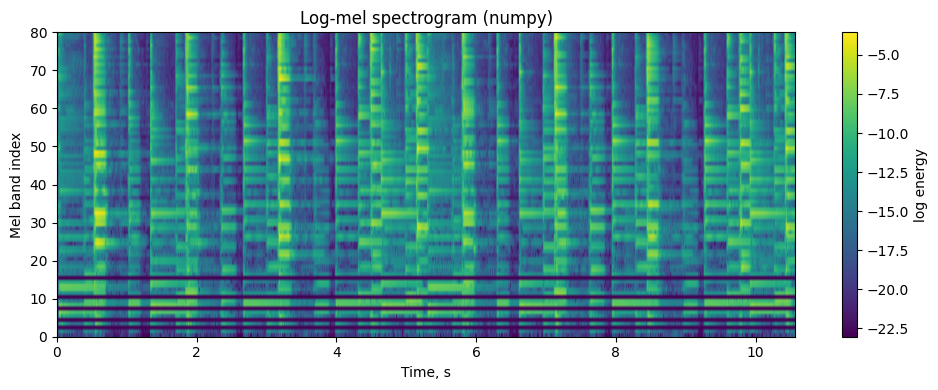

In [28]:
n_mels, n_frames = mel.shape
hop_length = int(round(sr * 10.0 / 1000.0))
duration_sec = n_frames * hop_length / sr

plt.figure(figsize=(10, 4))
plt.imshow(
    mel,
    origin="lower",
    aspect="auto",
    extent=[0, duration_sec, 0, n_mels],
)
plt.xlabel("Time, s")
plt.ylabel("Mel band index")
plt.title("Log-mel spectrogram (numpy)")
plt.colorbar(label="log energy")
plt.tight_layout()
plt.show()


In [29]:
import librosa

mel_librosa_power = librosa.feature.melspectrogram(
    y=x,
    sr=sr,
    n_fft=1024,
    hop_length=10.0,
    win_length=25.0,
    window="hann",
    center=False,
    power=2.0,
    n_mels=80,
    fmin=20.0,
    fmax=None,
    htk=True,          # mel-шкала HTK, ближе к тому, что обычно в лекциях
    norm=None,         # без доп. нормализации фильтров (как у нас)
)

log_mel_librosa = np.log(mel_librosa_power + 1e-10)

print("Наш mel shape:       ", mel.shape)          # твой результат
print("Librosa mel shape:   ", log_mel_librosa.shape)


ModuleNotFoundError: No module named 'librosa'